### Introduction

This notebook is an experiment of building a model that will predict if a rookie player will last at least 5 years in the league based on his stats.

In the National Basketball Association (NBA), a rookie is any player who has never played a game in the NBA until that year. At the end of the season the NBA awards the best rookie with the NBA Rookie of the Year Award.

Moving to the NBA league is a big deal for any basketball player. Sport commentators and fans are very excited to follow the start of their careers and guess how they will perform in the future.

In this experiment, SKlearn AdaBoost model is used.

### Import the libraries

In [20]:
import pandas as pd
import numpy as np

import os
import sys
sys.path.append(os.path.abspath('..'))
from src.common_lib import DataReader, NBARawData
from src.models.aj_metrics import confusion_matrix, plot_roc

# from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, accuracy_score, roc_curve, auc
from joblib import dump

from collections import Counter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data

In [14]:
# Instantiate the custom data reader class
data_reader = DataReader()

# Load Raw Train Data
train_df = data_reader.read_data(NBARawData.TRAIN)

# Load Test Raw Data
test_df = data_reader.read_data(NBARawData.TEST)

### Class Balance Check on Raw Data

Propotion:  0.2 :1
Counter({6669: 1, 1331: 1})


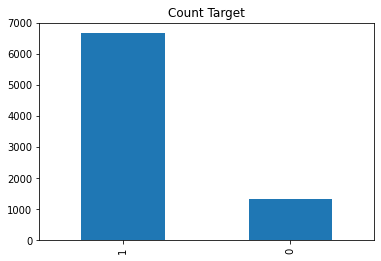

In [32]:
# target_count = train_df["TARGET_5Yrs"].value_counts()
# print('Propotion: ', round(target_count[0]/ target_count[1], 2), ":1")


# print( Counter(target_count))
# data_reader.plot_class_balance(train_df["TARGET_5Yrs"])

### Scaling with Standard Scaler

In [33]:
## Scaling
# df_cleaned = train_df.copy()
# target = df_cleaned.pop('TARGET_5Yrs')

# train_df_scaled = data_reader.scale_features_by_standard_scaler(df_cleaned)
# train_df_scaled

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0.930059,-1.731834,1.006100,0.640574,0.123403,0.113959,0.047090,0.177269,-0.428374,-0.486911,...,0.655953,0.760387,0.070392,1.428377,-0.121037,0.266040,1.161949,1.107242,-0.055071,0.473210
1,-0.380914,-1.731401,0.714005,0.360766,0.748626,0.822648,0.465578,1.704465,-1.469853,-1.712288,...,1.087875,1.319370,-0.341888,3.210407,1.100107,1.608950,-0.681844,-0.364787,0.432148,0.196671
2,-0.286878,-1.730968,1.298195,0.058574,-0.640758,-0.535673,-0.482994,-0.293888,0.352736,0.361427,...,-1.071732,-1.076272,0.415557,-0.608229,-0.264701,-0.405415,-0.608092,-0.610125,-0.055071,-0.909485
3,1.743194,-1.730535,0.012976,0.058574,0.216029,0.409246,0.130788,1.282049,0.092366,-0.015612,...,-0.531830,-0.357579,-0.428180,-0.353653,-0.121037,-0.117649,0.129425,-0.610125,-0.176876,0.888019
4,-0.348731,-1.730102,0.012976,-0.086926,-0.826009,-0.653788,-0.789885,1.005854,0.613106,0.549947,...,-1.287692,-1.156127,-1.665021,1.682952,0.381787,0.793612,-0.903099,-0.610125,0.432148,-0.771215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-0.970776,1.730102,-1.798014,-1.049465,-1.265980,-1.244362,-1.236272,-0.700057,-0.949113,-0.958210,...,-1.071732,-1.076272,-0.543235,-0.990093,-0.264701,-0.645220,-0.829347,-0.855464,-0.055071,-1.186024
7996,1.212418,1.730535,-0.512795,-1.407619,-1.265980,-1.244362,-1.347869,0.664672,-0.428374,-0.675430,...,-1.287692,-1.235982,-0.121366,-0.099078,-0.767525,-0.597259,-1.124354,-1.591478,0.066734,-1.324294
7997,-0.331885,1.730968,1.298195,1.077074,0.794939,0.704533,0.772469,0.079788,-0.168004,-0.204131,...,1.519796,1.558934,-0.159718,-0.099078,-0.049205,-0.069687,1.309452,1.352580,-0.055071,0.749749
7998,-1.399219,1.731401,-1.389081,-1.217350,-1.103885,-1.067190,-1.096776,-0.732551,-1.469853,-1.240989,...,-0.855771,-0.996417,0.281326,-0.862805,-1.126685,-1.124831,-1.050602,-0.855464,0.066734,-1.047755


### Select Features

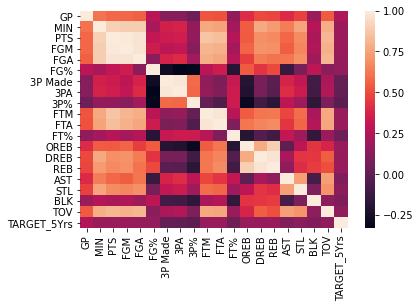

In [34]:
# train_df_scaled['TARGET_5Yrs'] = target
# selected_features = data_reader.select_feature_by_correlation(train_df_scaled)

In [35]:
selected_features

Index(['GP', 'MIN', 'FG%', '3P Made', '3P%', 'FTM', 'FT%', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')

### Split Train and Test on Scaled Data with Selected Features

In [15]:
#train_df_scaled  = train_df_scaled[selected_features]
X_train, X_val, y_train, y_val = data_reader.split_data(train_df)

In [16]:
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
model = abc.fit(X_train, y_train)

0.83734375


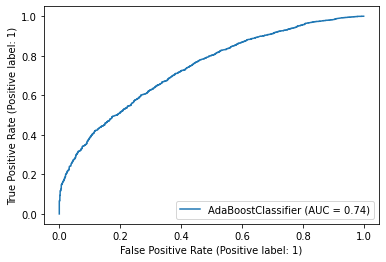

In [25]:
y_pred = model.predict(X_train)
# y_pred
plot_roc_curve(model, X_train, y_train)
print(accuracy_score(y_train, y_pred))

0.83375


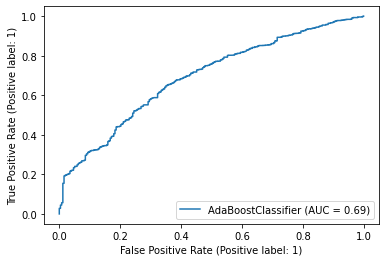

In [26]:
y_pred = model.predict(X_val)

plot_roc_curve(model, X_val, y_val)
print(accuracy_score(y_val, y_pred))

### Polynomial with Power 2

In [28]:
y_test_proba =model.predict_proba(test_df)[:,1]


final_prediction_test = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p for p in y_test_proba]})
final_prediction_test.to_csv("../reports/tin_submission_adaboost.csv", index=False)

final_prediction_test.head(10)

,Id,TARGET_5Yrs
0,0,0.506365
1,1,0.510259
2,2,0.514881
3,3,0.677121
4,4,0.510531
5,5,0.514822
6,6,0.507425
7,7,0.509431
8,8,0.509025
9,9,0.503222


In [54]:
# X_train_poly = data_reader.polynomialize_data(X_train, 2)
# X_val_poly = data_reader.polynomialize_data(X_val, 2)
# X_train_poly.shape

(6400, 105)

Counter({1: 5326, 0: 1074})


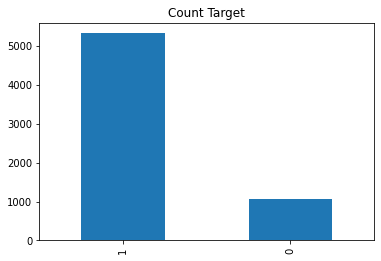

In [55]:
# ### Visualisation Before Sampling Classification Count
# print( Counter(y_train))
# data_reader.plot_class_balance(y_train)

Counter({1: 1343, 0: 257})


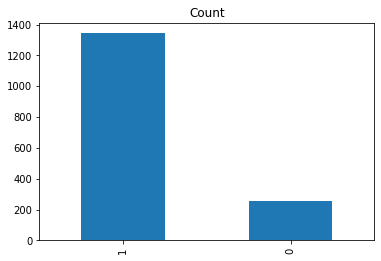

In [34]:
# print(Counter(y_val))
# data_reader.plot_class_balance(y_val)

### Re-sampling -  Over Sampling

In [59]:
X_val_res.shape

(2686, 105)

### Build The Model - Logistic Regression

### Accuracy Test on Train Set

### Accuracy Check on Validation Set

### Prediction on Test Set 